### sklearn_models 

The functions in this module allow the application of any scikit-learn regressor model that has
the methods .fit and .predict implemented. 
There are separate functions to train and evaluate (separate the data in train and test datasets),
train with all the data available, and make forecasts. Also, there is the possibility to transform 
the data using methods like sklearn.preprocessing.MinMaxScaler and save the models trained. This is useful when working with sklearn models as KNN (k-nearest neighbors) or SVR (support vector regression.).  

The functions whose name ends with `one` refer to those that apply just a single model. It means that to predict the next `X` days, will be trained just one model specialized in predict, give a day `D0`, the value in the day `D0 + X` using the lagged values. In this case, forecasting the next seven days, for example, will be necessary to use the last seven days of data. 

The functions whose name ends with `mult` refer to the functions that train multiple models to make the forecast. It means that to predict the next `X` days, will be trained `X` models, each one being specialized in predicting, give a day `D0`, the value in the day `D0 + I`, where I is in the range \[1,`X`\]. In this case, to forecast the next seven days, for example, it will be necessary to apply seven different models on the last day of data. 

Let's import the necessary packages:

In [1]:
import os 
import pandas as pd 
import lightgbm as lgb
import matplotlib.pyplot as plt
os.chdir('/Users/eduardoaraujo/Documents/GitHub/epigraphhub_py')
from epigraphhub.data.get_data import get_cluster_data, get_georegion_data
from epigraphhub.models.sklearn_models import *
os.chdir('/Users/eduardoaraujo/Documents/GitHub/epigraphhub_py/examples')

First, let's download a dataset from our platform to use as an example. To do this, we will use the function `get_cluster_data`. This function, by default, is configured to work well with the Switzerland covid data. In the example below, the result will be a data frame with datetime index. The columns are related to the time series of tests, cases, and hospitalizations in Geneva and your first and second order differences.

In [2]:
%%time
df = get_cluster_data('switzerland', ['foph_test_d', 'foph_cases_d', 'foph_hosp_d'], ['GE'], vaccine = False)

df

CPU times: user 111 ms, sys: 14 ms, total: 125 ms
Wall time: 10.2 s


,test_GE,diff_test_GE,diff_2_test_GE,cases_GE,diff_cases_GE,diff_2_cases_GE,hosp_GE,diff_hosp_GE,diff_2_hosp_GE
datum,,,,,,,,,
2020-03-01,0.000000,0.000000,0.000000,1.428571,0.142857,0.142857,0.428571,0.000000,0.000000
2020-03-02,0.000000,0.000000,0.000000,1.714286,0.285714,0.428571,0.428571,0.000000,0.142857
2020-03-03,0.000000,0.000000,0.000000,1.714286,0.000000,0.285714,0.428571,0.000000,0.000000
2020-03-04,0.000000,0.000000,0.000000,1.714286,0.000000,0.000000,0.571429,0.142857,0.142857
2020-03-05,0.000000,0.000000,0.000000,1.857143,0.142857,0.142857,0.857143,0.285714,0.428571
...,...,...,...,...,...,...,...,...,...
2022-05-06,859.000000,-8.142857,-16.142857,143.000000,-7.142857,-16.428571,4.285714,-0.285714,-0.285714
2022-05-07,858.000000,-1.000000,-9.142857,139.428571,-3.571429,-10.714286,3.428571,-0.857143,-1.142857
2022-05-08,856.285714,-1.714286,-2.714286,139.571429,0.142857,-3.428571,3.000000,-0.428571,-1.285714


To learn how to use the functions, let's use the function defined below called `lgbm_model` to create an LGBM regressor model. If you want to use other parameters in this function, you should put them in a dictionary and pass them in the parameter `params`. 

In [3]:
def lgbm_model(params=None):
    '''
    Return an LGBM model
    :param params: parameters of the LGBM model. 
    :return: LGBMRegressor model
    '''
    if params is None:
        params = {
            'n_jobs': 8,
            'max_depth': 4,
            'max_bin': 63,
            'num_leaves': 255,
#             'min_data_in_leaf': 1,
            'subsample': 0.9,
            'n_estimators': 200,
            'tree_learner': 'feature', 
            'learning_rate': 0.1,
            'colsample_bytree': 0.9,
            'boosting_type': 'gbdt'
        }


    model = lgb.LGBMRegressor(objective='regression', **params)

    return model 

Let's define the model below:

In [4]:
model = lgbm_model() 

### Function  `rolling_predictions_one()`:


This function train one model trained to predict the X + {horizon_forecast} day. 

This function has the following parameters: 
    
* `model`: model to apply in the data. It should be passed a model compatible with the sklearn .fit and .predict methods;  
* `target_name`: Name of the target column. This column should belong to the dataset `data`. Type = `string`;
* `data`: Dataframe with features and target column. Type= `pandas dataframe`;
* `ini_date`: Determines the beginning of the training dataset. Type = `string`;
* `split`: Determines which percentage of the data will be used to train the model. Type = `float`. Default = 0.75;
* `horizon_forecast`: Determines the number of days that will be predicted. Type = `int`. Default = 14;
* `max_lag`: Determines the number of the last days used as features to forecast the next days. Type = `int`. Default = 14;
* `norm`: decide if the data will be normalized. Type = 'boolean'. Default = False;
* `norm_model_x`: model to normalize the features. Default = MinMaxScaler();
* `norm_model_y`: model to normalize the targets. Default = MinMaxScaler();
* `save`: decides if the models will be save. Type = `boolean`. Default = False;  
* `path`: decides in which folder the models will be saved. Type = `string|None`. If None it will be saved in the current directory;
* `label`: add a different name annotation for the  models saved. Type = `string`. Default = 'test'. 

By default the model is saved as:
* `trained_model_norm_{label}_{horizon_forecast}D.joblib` (when norm == True);
* `trained_model_{label}_{horizon_forecast}D.jobli` (when norm == False).

If `norm = True`, it's also necessary to save the models used to normalize the features and targets. In this case, these models are saved as: 
* `features_norm_{label}.joblib`, for the `norm_model_x` (just applied and saved when norm == True);
* `target_norm_{label}D.joblib`, for the `norm_model_y` (just applied and saved when norm == True).

and the returns:
* `df_pred`: DataFrame with the target values and the predictions. The data frame has the following columns: `target`, with the values used to train and test the model, 	`predict`, with the predicted values and `train_size`, with the number of target observations used to train the model. The dataframe also have a datetime index. Type: `pandas Dataframe`;
* `model`: the trained and tested model;
* `scx`: If norm = True, this represents the model used to normalize the features. Otherwise the return is None;
* `scy`: If norm = True, this represents the model used to normalize the targets. Otherwise the return is None. 


Let's use this function to predict the values in the `hosp_GE` column:

In [5]:
%%time
target_name = 'hosp_GE'
df_pred_one, models_one, scx_one, scy_one = rolling_predictions_one(
    model, target_name,
    df, ini_date="2020-03-01",
    split=0.75, horizon_forecast=14, maxlag=14,
    norm = True, norm_model_x =  MinMaxScaler(),
    norm_model_y =  MinMaxScaler(), 
    save = False, path = None, label= 'test')

CPU times: user 582 ms, sys: 61.5 ms, total: 643 ms
Wall time: 111 ms


To plot the results obtained in the variable `df_pred_one` let's use the function explained below:

### Function  `plot_predicted_vs_data()`:

This function can be used to plot the data frame with the predictions obtained in the `rolling_predictions_one()` or `rolling_predictions_mult()` function. The function has the following parameters: 

* `df_pred`. It's a pandas Dataframe obtained in the function `rolling_predictions()`. Type = `pandas Dataframe`;
* `title`. It's the string that will be used as the plot's title. Type = `string`. Default = 'Ngboost predictions';
* `save`. If `True`, the plot will be saved. Type = `boolean`. Default = False;
* `filename` It's the string with the name that will be used to save the plot. Type = `string`. Default = 'ngboost_pred';
* `path`. decides in which folder the plot will be saved. Type = `string|None`. If None it will be saved in the current directory;

The return is None. 


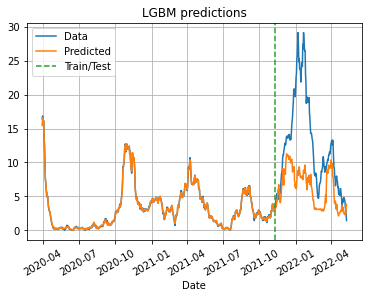

In [6]:
plot_predicted_vs_data(df_pred_one, title = 'LGBM predictions')

### Function  `training_model_one()`:

To train one model with all the data available and save it, we can use the `training_model_one()` function.

This function has the following parameters: 

* `model`: model to apply in the data. It should be passed a model compatible with the sklearn .fit and .predict methods;  
* `target_name`: Name of the target column. This column should belong to the dataset `data`. Type = `string`;
* `data`: Dataframe with features and target column. Type= `pandas dataframe`;
* `ini_date`: Determines the beginning of the training dataset. Type = `string`;
* `split`: Determines which percentage of the data will be used to train the model. Type = `float`. Default = 0.75;
* `horizon_forecast`: Determines the number of days that will be predicted. Type = `int`. Default = 14;
* `max_lag`: Determines the number of the last days used as features to forecast the next days. Type = `int`. Default = 14;
* `norm`: decide if the data will be normalized. Type = 'boolean'. Default = False;
* `norm_model_x`: model to normalize the features. Default = MinMaxScaler();
* `norm_model_y`: model to normalize the targets. Default = MinMaxScaler();
* `save`: decides if the models will be save. Type = `boolean`. Default = False;  
* `path`: decides in which folder the models will be saved. Type = `string|None`. If None it will be saved in the current directory;
* `label`: add a different name annotation for the  models saved. Type = `string`. Default = 'test'. 

By default the model is saved as:
* `trained_model_norm_{label}_{horizon_forecast}D.joblib` (when norm == True);
* `trained_model_{label}_{horizon_forecast}D.jobli` (when norm == False).

If `norm = True`, it's also necessary to save the models used to normalize the features and targets. In this case, these models are saved as: 
* `features_norm_{label}.joblib`, for the `norm_model_x` (just applied and saved when norm == True);
* `target_norm_{label}D.joblib`, for the `norm_model_y` (just applied and saved when norm == True).

and the returns:
* `model`: the trained and tested model;
* `scx`: If norm = True, this represents the model used to normalize the features. Otherwise the return is None;
* `scy`: If norm = True, this represents the model used to normalize the targets. Otherwise the return is None. 


Let's train a model with all the data available in the cell below:

In [7]:
trained_model, trained_scx, trained_scy = training_model_one(
    model,
    target_name,
    df,
    ini_date="2020-03-01",
    horizon_forecast=14,
    maxlag=14,
    norm_model_x =  MinMaxScaler(), norm_model_y =  MinMaxScaler(),  norm = False,
    save = True, path = 'saved_sklearn_models',  label= 'lgbm_one')

### Function `rolling_forecast_one()`:

This function forecasts a time series using, like features, the last observation of the `data` param and the **saved** models trained with `training_model_one()`. The `horizon_forecast` and `maxlag` parameters should be the same used in the `training_model_one()`. 

This function will return a Dataframe with the following columns: `lower`, with the lower value of the confidence interval of the predictions,`median` with the median values of the predictions,	`upper`, with the upper value of the confidence interval, and a datetime index.

This function has the following parameters:

* `target_name` Name of the target column, this column should belong to the dataset data. Type = string;
* `data`: Dataframe with features and target column. Type= pandas Dataframe;
* `horizon_forecast`:  Determines the number of days that will be predicted. Type = `int`. Default = 14;
* `maxlag`: Determines the number of the last days used as features to forecast the next days. Type = `int`. Default = 14;
* `path`: decides in which folder the models will be saved. Type = `string|None`. If None it will be saved in the current directory. Default="../opt/models/saved_models/ml".

and the returns:

* `df_for`: DataFrame with the forecasted values. T he data frame has only the column `forecast`, with the forecasted value.The dataframe also have a datetime index. Type: `pandas Dataframe`;

Let's apply the forecast using the trained model saved in the `path = 'saved_sklearn_models'`.

In [8]:
df_for = rolling_forecast_one(target_name,df, horizon_forecast = 14, maxlag = 14, norm = False, path = 'saved_sklearn_models', label= 'lgbm_one')

In [9]:
df_for.shape[0]

14

To plot the results obtained in the variable `df_for` let's use the function explained below:

### Function  `plot_forecast()`:

This function can be used to plot the data frame with the forecast obtained in the `rolling_forecast()` function. It's also necessary to provide a dataset with the data before the forecasted values (the same dataset provided in the `data` parameter of the `rolling_forecast()` function). The function has the following parameters: 

* `df`: It's a pandas Dataframe with the data used to make the forecast. Type = `pandas dataframe`. 
  
* `target_name`: Name of the target column forecasted. Type = `string`. 

* `df_for`: It's a dataframe  with the forecasted values, it's must have the following columns: lower, median, upper and a datetime index. Type = `pandas Dataframe`.  
                    
* `last_values`: Number of last values of the df show in the plot. Type = `int`. Default = 90. 
          
* `title`: This string is used as the plot's title. Type = `string`. Default = `Ngboost forecast`. 
 
* `save`: If true the plot is saved. Type = `boolean`. Default = False
    
* `filename`: Name of the png file where the plot is saved. Type = `string`. Default = `ngboost_forecast`.  
    
* `path`: Path where the figure must be saved. If None the figure is saved in the current directory. Type = `string|None`. Default = None. 

The return is None. 


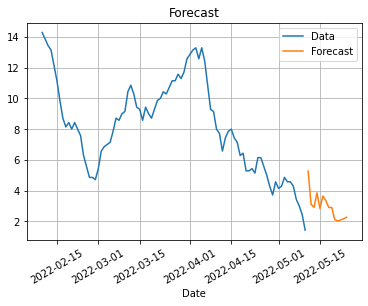

In [10]:
plot_forecast(df, target_name, df_for, last_values = 90, title = 'Forecast', save = False, filename = 'forecast', path = None)

### Function  `rolling_predictions_mult()`:


This function train `horizon_forecast` models. Each model is trained to predict the value in the X + {T} day, being T in the range \[1, horizon_forecast\]. 

This function has the following parameters: 
    
* `model`: model to apply in the data. It should be passed a model compatible with the sklearn methods.  
* `target_name`: Name of the target column. This column should belong to the dataset `data`. Type = `string`;
* `data`: Dataframe with features and target column. Type= `pandas dataframe`;
* `ini_date`: Determines the beginning of the training dataset. Type = `string`;
* `split`: Determines which percentage of the data will be used to train the model. Type = `float`. Default = 'split';
* `horizon_forecast`: Determines the number of days that will be predicted. Type = `int`. Default = 14;
* `max_lag`: Determines the number of the last days used as features to forecast the next days. Type = `int`. Default = 14;
* `norm`: decide if the data will be normalized. Type = 'boolean'. Default = False.  
* `norm_model_x`: model to normalize the features. Default = MinMaxScaler()
* `norm_model_y`: model to normalize the targets. Default = MinMaxScaler()
* `save`: decides if the models will be save. Type = `boolean`.  
* `path`: decides in which folder the models will be saved. Type = `string`
* `label`: add a different name annotation for the  models saved. Type = `string`. Default = 'test'. 

By default the models trained are saved as:
* 'trained_model_norm_{label}_{T}D.joblib' (when norm == True)
* 'trained_model_{label}_{T}D.joblib' (when norm == False)

for each T in the range \[1, horizon_forecast\]. 

If `norm = True`, it's also necessary to save the models used to normalize the features and targets. In this case, this model are saved as: 
* 'feature_norm_{label}.joblib', for the `norm_model_x` (just applied and saved when norm == True)
* 'target_norm_{label}_{T}D.joblib', for the `norm_model_y` (just applied and saved when norm == True)
for each T in the range \[1, horizon_forecast\]. 

and the returns:
* df_pred. DataFrame with the target values and the predictions. The data frame has the following columns: `target`, with the values used to train and test the model, 	`predict`, with the predicted values and `train_size`, with the number of target observations used to train the model. The dataframe also has a datetime index. Type: `pandas Dataframe`.
* model: dictionary with the models trained. The key value is the number of days ahead that the model was trained to predict. Type:`dictionary`. 
* scx: If norm = True, this represents the model used to normalize the features. Otherwise, the return is None. 
* dict_scy: If norm = True, this represents the dictionary with the models used to normalize the targets. Otherwise, the return is an empty dictionary. 


In [11]:
model = lgbm_model() 

target_name = 'hosp_GE'

df_pred_mult, models_mult, scx_mult, dict_scy_mult = rolling_predictions_mult(
    model, target_name,
    df, ini_date="2020-03-01",
    split=0.75, horizon_forecast=14, maxlag=14,
    norm = True, norm_model_x =  MinMaxScaler(),
    norm_model_y =  MinMaxScaler(), 
    save = False, path = None, label= 'test')

We can plot the result obtained above used the `plot_predicted_vs_data` function. 


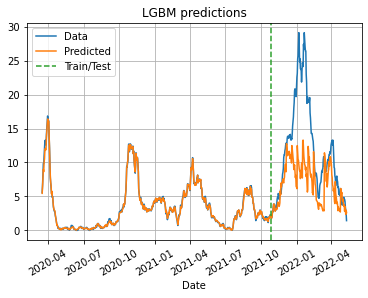

In [12]:
plot_predicted_vs_data(df_pred_mult, title = 'LGBM predictions')

### Function  `training_model_mult()`:

We can use the `training_model_mult()` function to train multiple models with all the available data and save it.

This function has the following parameters: 

* `model`: a model to apply in the data. It should be passed a model compatible with the sklearn methods.  
* `target_name`: Name of the target column. This column should belong to the dataset `data`. Type = `string`;
* `data`: Dataframe with features and target column. Type= `pandas dataframe`;
* `ini_date`: Determines the beginning of the training dataset. Type = `string`;
* `horizon_forecast`: Determines the number of days that will be predicted. Type = `int`. Default = 14;
* `max_lag`: Determines the number of the last days used as features to forecast the next days. Type = `int`. Default = 14;
* `norm`: decide if the data will be normalized. Type = 'boolean'. Default = False.  
* `norm_model_x`: model to normalize the features. Default = MinMaxScaler()
* `norm_model_y`: model to normalize the targets. Default = MinMaxScaler()
* `save`: decides if the models will be saved. Type = `boolean`.  
* `path`: decides in which folder the models will be saved. Type = `string`
* `label`: add a different name annotation for the  models saved. Type = `string`. Default = 'test'. 

By default the models trained are saved as:
* 'trained_model_norm_{label}_{T}D.joblib' (when norm == True)
* 'trained_model_{label}_{T}D.joblib' (when norm == False)

for each T in the range \[1, horizon_forecast\]. 

If `norm = True`, it's also necessary to save the models used to normalize the features and targets. In this case, this model are saved as: 
* 'feature_norm_{label}.joblib', for the `norm_model_x` (just applied and saved when norm == True)
* 'target_norm_{label}_{T}D.joblib', for the `norm_model_y` (just applied and saved when norm == True)
for each T in the range \[1, horizon_forecast\]. 

and the returns:
* model: dictionary with the models trained. The key value is the number of days ahead that the model was trained to predict. Type:`dictionary`. 
* scx: If norm = True, this represents the model used to normalize the features. Otherwise, the return is None. 
* dict_scy: If norm = True, this represents the dictionary with the models used to normalize the targets. Otherwise, the return is an empty dictionary. 


Let's train multiple models with all the data available in the cell below:

In [13]:
trained_model_mult, scx_mult, scy_mult = training_model_mult(
    model,
    target_name,
    df,
    ini_date="2020-03-01",
    horizon_forecast=14,
    maxlag=14,
    norm_model_x =  MinMaxScaler(), norm_model_y =  MinMaxScaler(),  norm = False,
    save = True, path = 'saved_sklearn_models',  label= 'lgbm_mult')


### Function `rolling_forecast_mult()`:

This function forecasts a time series using, like features, the last observation of the `data` param and the **saved** models trained with `training_model_mult()`. The `horizon_forecast` and `maxlag` parameters should be the same used in the `training_model_mult()`. 

This function will return a Dataframe with the following columns: `lower`, with the lower value of the confidence interval of the predictions,`median` with the median values of the predictions,	`upper`, with the upper value of the confidence interval, and a datetime index.

This function has the following parameters:

* `target_name` Name of the target column, this column should belong to the dataset data. Type = string;
* `data`: Dataframe with features and target column. Type= pandas Dataframe;
* `horizon_forecast`:  Determines the number of days that will be predicted. Type = `int`. Default = 14;
* `maxlag`: Determines the number of the last days used as features to forecast the next days. Type = `int`. Default = 14;
* `path`: decides in which folder the models will be saved. Type = `string|None`. If None it will be saved in the current directory. Default="../opt/models/saved_models/ml".

and the returns:

* `df_for`: DataFrame with the forecasted values. T he data frame has only the column `forecast`, with the forecasted value.The dataframe also have a datetime index. Type: `pandas Dataframe`;

Let's apply the forecast using the trained model saved in the `path = 'saved_sklearn_models'` and saved with the label `lgbm_mult`.

In [14]:
df_for = rolling_forecast_mult(
    target_name,
    df,
    horizon_forecast = 14,
    maxlag = 14,
    norm = False,
    path = 'saved_sklearn_models',
    label= 'lgbm_mult')
    

To plot the results obtained in the variable `df_for` let's use the function explained below:

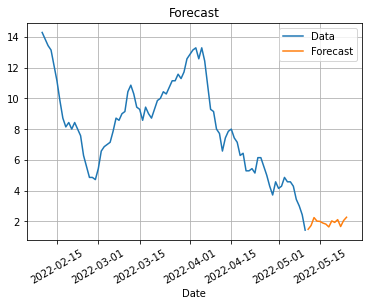

In [15]:
plot_forecast(df, target_name, df_for, last_values = 90, title = 'Forecast', save = False, filename = 'forecast', path = None)